_Stefano Maxenti - maxenti.s@northeastern.edu_

# EECE 7398: Verifiable Machine Learning -- Fall 2023
# HW#3: Reachability Analysis of Neural Feedback Loops

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.

The goal of this assignment is to give you hands-on experience with reachability analysis of neural feedback loops. You will code some forward and backward reachability algorithms, leveraging existing NN verification libraries. Depending on your interests, you are encouraged to try implementing some sort of extension for the extra credit problem.

You're welcome to use Jax, PyTorch, TensorFlow, Keras, or other appropriate libraries to help make your life easier throughout the problems - we provide examples based on `jax_verify` but tried to make the function signatures somewhat framework-agnostic.

# Dependencies, Imports, & Useful Functions

In [1]:
!apt install libgmp-dev
!pip install \
    "jax_verify @ git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git" \
    "crown_ibp @ git+https://gitlab.com/neu-autonomy/certifiable-learning/crown_ibp.git" \
    nfl_veripy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgmpxx4ldbl
Suggested packages:
  gmp-doc libgmp10-doc libmpfr-dev
The following NEW packages will be installed:
  libgmp-dev libgmpxx4ldbl
0 upgraded, 2 newly installed, 0 to remove and 19 not upgraded.
Need to get 346 kB of archives.
After this operation, 1,702 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmpxx4ldbl amd64 2:6.2.1+dfsg-3ubuntu1 [9,580 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmp-dev amd64 2:6.2.1+dfsg-3ubuntu1 [337 kB]
Fetched 346 kB in 0s (3,418 kB/s)
Selecting previously unselected package libgmpxx4ldbl:amd64.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../libgmpxx4ldbl_2%3a6.2.1+dfsg-3ubuntu1_amd64.deb ...
Unpacking libgmpxx4ldbl:amd64 (2:6.2.1+dfsg-3ubuntu1) ...
Selecting previously unsel

In [30]:
import argparse  # noqa: E402
import ast  # noqa: E402
import logging  # noqa: E402
import os  # noqa: E402
import time  # noqa: E402
from typing import Dict, Tuple  # noqa: E402

import numpy as np  # noqa: E402
import yaml  # noqa: E402

import nfl_veripy.analyzers as analyzers  # noqa: E402
import nfl_veripy.constraints as constraints  # noqa: E402
import nfl_veripy.dynamics as dynamics  # noqa: E402
from nfl_veripy.utils.nn import load_controller  # noqa: E402
from nfl_veripy.utils.utils import get_plot_filename  # noqa: E402

import torch
import numpy as np
import cvxpy as cp
from enum import Enum
import matplotlib.pyplot as plt
import jax_verify
import functools
import jax.numpy as jnp
from typing import Callable, Optional
from matplotlib.patches import Rectangle
from itertools import product

import time

Some possibly useful methods for defining a NN in jax, copied in from the last HW assignment:

In [31]:
def pytorch_model_to_jax(torch_model: torch.nn.Sequential):
  params = []
  act = None

  # Extract params (weights, biases) from torch layers, to be used in
  # jax.
  # Note: This propagator assumes a feed-forward relu NN.
  for m in torch_model.modules():
    if isinstance(m, torch.nn.Sequential):
      continue
    elif isinstance(m, torch.nn.ReLU):
      if act is None or act == "relu":
        act = "relu"
    elif isinstance(m, torch.nn.Linear):
      w = m.weight.data.numpy().T
      b = m.bias.data.numpy()
      params.append((w, b))
  return functools.partial(relu_nn, params)

def relu_nn(params, inputs):
  for W, b in params[:-1]:
    outputs = jnp.dot(inputs, W) + b
    inputs = jnp.maximum(outputs, 0)
  W, b = params[-1]
  return jnp.dot(inputs, W) + b

def jax_interval_to_np_range(interval: jax_verify.IntervalBound) -> np.ndarray:
  return np.vstack([interval.lower, interval.upper]).T

def np_range_to_jax_interval(input_range: np.ndarray) -> jax_verify.IntervalBound:
  return jax_verify.IntervalBound(input_range[:, 0], input_range[:, 1])

Here are some methods as examples of working with the controller and dynamics:

In [32]:
# Load a dynamics model that implements x_{t+1} = Ax_{t} + Bu_{t} for a ground robot
dyn = dynamics.get_dynamics_instance("GroundRobot", "FullState")
# Load a controller for the ground robot that is trained to avoid an obstacle near the origin
controller = load_controller("GroundRobotSI", model_name="complex_potential_field")
jax_controller = pytorch_model_to_jax(controller)

# Problem 1: Forward Reachability Analysis

Here is an example of how to implement the closed-loop dynamics for 1 step (`step_1`) and plot some randomly sampled ($x_t, x_{t+1})$ pairs (`plot_1step_samples_and_bounds`):

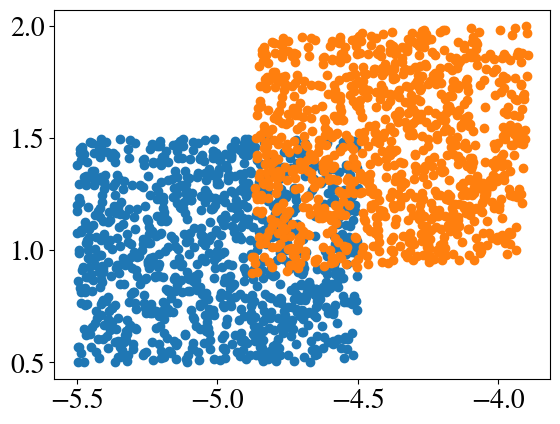

In [33]:
def step_1(xt):
  ut = jax_controller(xt)
  xt1 = dyn.dynamics_step_jnp(xt, ut)
  return xt1

def plot_1step_samples_and_bounds(initial_state_range: np.ndarray, step_fn: Callable, bounds: Optional[np.ndarray]) -> None:

  xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(1000,2))
  xt1 = step_fn(xt)
  plt.plot(xt[:, 0], xt[:, 1], 'o')
  plt.plot(xt1[:, 0], xt1[:, 1], 'o')
  dims = [0, 1]
  if bounds is not None:
    rect = Rectangle(
        bounds[dims, 0],
        bounds[dims[0], 1] - bounds[dims[0], 0],
        bounds[dims[1], 1] - bounds[dims[1], 0],
        fc="None",
        linewidth=2,
        edgecolor="red",
    )
    plt.gca().add_patch(rect)
  plt.show()

initial_state_range = np.array([[-5.5,-4.5],[.5,1.5]])
plot_1step_samples_and_bounds(initial_state_range, step_1, bounds=None)

## 1a) Calculate outer bounds on the 1-step reachable set [DONE]

You'll start by implementing a function that calculates outer bounds on the 1-step reachable set. It's up to you how you do this, but as an example, you could do this in 3 lines using `jax_verify`.

**Deliverables**:
- Implement `compute_1step_reachable_set`
- Plot your computed reachable set bounds over the Monte Carlo samples

1-step Reachable Set:
[[-4.8822904 -3.8872879]
 [ 0.8987891  2.011671 ]].


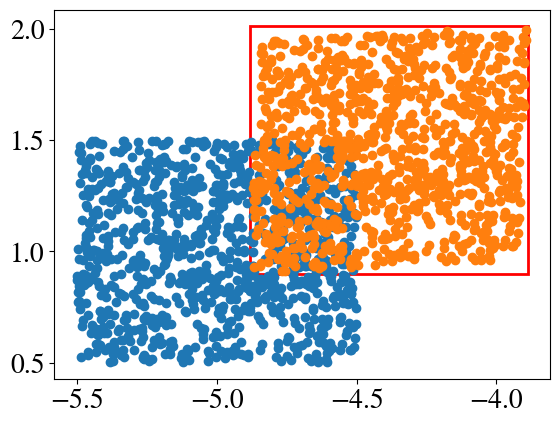

EXECUTION TIME:  0.1323690414428711  s


In [34]:
def compute_1step_reachable_set(initial_state_range: np.ndarray, step_fn: Callable) -> np.ndarray:

  # - initial_state_range: np.array of size (num_states, 2) containing min/max per state
  # - step_fn: function that takes 1 argument, x_t, and outputs the subsequent state, x_{t+1}
  #
  # Returns:
  # - next_state_range: np.array of same shape as initial_state_range, but corresponding to the next timestep

  input_bounds = np_range_to_jax_interval(initial_state_range)
  output_bounds_crown_jax = jax_verify.backward_crown_bound_propagation(step_1, input_bounds)
  next_state_range = jax_interval_to_np_range(output_bounds_crown_jax)

  return next_state_range

start_time = time.time()
output_range = compute_1step_reachable_set(initial_state_range, step_1)
end_time = time.time()
print(f"1-step Reachable Set:\n{output_range}.")

# You can pass the computed output_range to the function we defined before
# and it will draw your bound as a rectangle over the sampled points:
plot_1step_samples_and_bounds(initial_state_range, step_1, bounds=output_range)
print("EXECUTION TIME: ", end_time-start_time, " s")

## 1b) Calculate outer bounds on the reachable sets for T steps into the future: Iterative Version [DONE]

Now that you have a 1-step reachable set algorithm, you will extend this to compute reachable sets T steps into the future.

**Deliverables**:
- Implement `compute_Tstep_reachable_set_iterative`, an iterative algorithm to get reachable set outer bounds for timesteps $(1, 2, ..., T)$.



To help out, we provide you with a function to plot those samples (and bounds, for later parts of the problem), so you can see what the forward reachable sets should roughly look like:

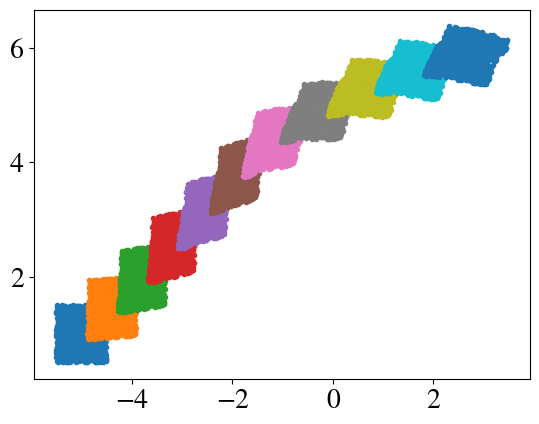

In [35]:
def plot_Tstep_samples_and_bounds(initial_state_range: np.ndarray, step_1: Callable, num_steps: int, bounds: Optional[np.ndarray]) -> None:

  # Sample a bunch of points in the initial state set, then run those forward T steps and plot
  xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(1000,2))
  plt.plot(xt[:, 0], xt[:, 1], '.')
  for _ in range(num_steps):
    xt = step_1(xt)
    plt.plot(xt[:, 0], xt[:, 1], '.')

  # If passed in, draw the bounds as a rectangle at each timestep
  if bounds is not None:
    for bound in bounds:
      dims = [0, 1]
      rect = Rectangle(
          bound[dims, 0],
          bound[dims[0], 1] - bound[dims[0], 0],
          bound[dims[1], 1] - bound[dims[1], 0],
          fc="None",
          linewidth=2,
          edgecolor="red",
      )
      plt.gca().add_patch(rect)
  plt.show()

initial_state_range = np.array([[-5.5,-4.5],[.5,1.5]])
num_steps = 10
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=None)

Now that you have visualized what the reachable sets should roughly look like, you will implement an algorithm to compute outer bounds on those reachable sets.

Your first implementation will compute reachable sets iteratively, as in:

- $\bar{R}_1(X_t) = \texttt{compute_1step_reachable_set}(X_t)$
- $\bar{R}_2(X_t) = \texttt{compute_1step_reachable_set}(\bar{R}_1(X_t))$
- $\ldots$

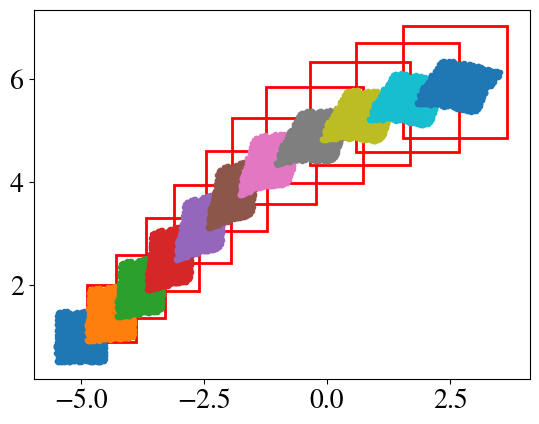

output ranges:
[[-4.8822904 -3.8872879]
 [ 0.8987891  2.011671 ]]
[[-4.275136  -3.281085 ]
 [ 1.3574758  2.5879688]]
[[-3.6760807 -2.6015022]
 [ 1.8780321  3.3096683]]
[[-3.1113975 -1.9450148]
 [ 2.436414   3.942549 ]]
[[-2.4675899 -1.2098205]
 [ 3.049322   4.5994115]]
[[-1.9278027  -0.23395538]
 [ 3.5746593   5.2494392 ]]
[[-1.2459025  0.7240847]
 [ 3.9897215  5.8515997]]
[[-0.35582852  1.6924036 ]
 [ 4.331205    6.324141  ]]
[[0.5871786 2.6773362]
 [4.5911303 6.7082605]]
[[1.5456668 3.6538568]
 [4.846645  7.022326 ]]
EXECUTION TIME:  1.2350785732269287  s


In [36]:
def compute_Tstep_reachable_set_iterative(initial_state_range: np.ndarray, step_fn: Callable, num_steps: int) -> np.ndarray:
  #
  # initial_state_range: (num_states, 2) array containing min/max per state
  # step_fn: function that accepts array of state samples at initial timestep and returns list of state samples at times [t+1, ..., t+num_steps]
  # num_steps: non-negative integer
  #
  # Return:
  # - list of state_ranges at times [t+1, t+2, ..., t+num_steps]
  #  i.e., [(num_states, 2)_t=t+1, ..., (num_states, 2)_t=t+T]

  # TODO: implement this using
  output_range = []
  for _ in range(num_steps):
    newer_range = compute_1step_reachable_set(initial_state_range, step_1)
    initial_state_range = newer_range
    output_range.append(newer_range)
  return output_range

initial_state_range = np.array([[-5.5,-4.5],[.5,1.5]])
start_time = time.time()
output_ranges = compute_Tstep_reachable_set_iterative(initial_state_range, step_1, num_steps)
end_time = time.time()
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=output_ranges)

print('output ranges:')
for output_range in output_ranges:
  print(output_range)

print("EXECUTION TIME: ", end_time-start_time, " s")

**From the result, I see that the farther I go from the original state, the looser the bounds become.**

## 1c) Calculate outer bounds on the reachable sets for T steps into the future: One-Shot Version [DONE]

Iterative reachability analysis can provide excessively conservative bounds, for several reasons. To address this, you will implement one way to get tighter bounds, by instead computing the bounds for all timesteps in one-shot, i.e.,

- $\bar{R}_T(X_t), \ldots, \bar{R}_2(X_t), \bar{R}_1(X_t) = \texttt{compute_Tstep_reachable_set}(X_t, T)$

Remember, if the function you ask `jax_verify` to compute bounds on returns a list of outputs, you will get a list of bounds that corresponds to each output in the list. We've helped you out by implementing `step_T`, which outputs a list of future states for a given initial state. Since `jax_verify` expects the function to verify just has 1 argument (e.g., the initial state), it's helpful to use `functools.partial` to set any other arguments to a particular value (e.g., `num_steps`).

**Deliverables**:
- Implement `compute_Tstep_reachable_set_one_shot`
- Briefly comment on the difference between the two algorithms' bounds and runtimes

In [37]:
def step_T(num_steps: int, xt: np.ndarray) -> list[np.ndarray]:
  #
  # num_steps: non-negative integer
  # xt: (num_samples, num_states) np array of state samples at time t
  #
  # Return:
  # - list of state samples at times [t+1, t+2, ..., t+num_steps]
  #  i.e., [(num_samples, num_states)_t=t+1, ..., (num_samples, num_states)_t=t+num_steps]
  #
  # jax_verify will by default compute bounds on any "outputs" of the function
  # to verify, so if you return a list of states at each timestep, you'll
  # get bounds on all reachable sets in one call.

  xts = [xt]
  for _ in range(num_steps):
    ut = jax_controller(xts[-1])
    xts.append(dyn.dynamics_step_jnp(xts[-1], ut))
  return xts[1:]

num_steps = 10
step_fn = functools.partial(step_T, num_steps)

step_fn(np.array([[-5., 0.]]))

[Array([[-4.4174013,  0.3473388]], dtype=float32),
 Array([[-3.847242 ,  0.8128644]], dtype=float32),
 Array([[-3.283502 ,  1.3380518]], dtype=float32),
 Array([[-2.723895 ,  1.9251441]], dtype=float32),
 Array([[-2.1296759,  2.5561213]], dtype=float32),
 Array([[-1.5110402,  3.2019758]], dtype=float32),
 Array([[-0.77865285,  3.8047707 ]], dtype=float32),
 Array([[0.16298664, 4.276965  ]], dtype=float32),
 Array([[1.1204667, 4.6570745]], dtype=float32),
 Array([[2.0942688, 4.9557834]], dtype=float32)]

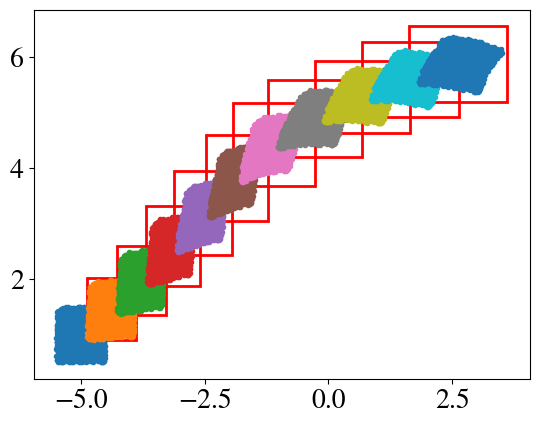

output ranges:
[[-4.8822904 -3.8872879]
 [ 0.8987891  2.011671 ]]
[[-4.275136  -3.2810853]
 [ 1.3574759  2.5879686]]
[[-3.676081  -2.601503 ]
 [ 1.878032   3.3096678]]
[[-3.111398  -1.9468963]
 [ 2.4364142  3.9409275]]
[[-2.4659517 -1.2204304]
 [ 3.0502415  4.596188 ]]
[[-1.9200661 -0.2627144]
 [ 3.6702561  5.1575475]]
[[-1.2112474  0.6854067]
 [ 4.1844134  5.5828156]]
[[-0.27896404  1.6496248 ]
 [ 4.629635    5.9222684 ]]
[[0.66892624 2.6304379 ]
 [4.918289   6.268758  ]]
[[1.6329088 3.6053257]
 [5.176407  6.5426116]]
EXECUTION TIME:  8.786011695861816  s


In [38]:
def compute_Tstep_reachable_set_one_shot(initial_state_range: np.ndarray, step_fn: Callable, num_steps: int) -> np.ndarray:
  #
  # initial_state_range: (num_states, 2) array containing min/max per state
  # step_fn: function that accepts array of state samples at initial timestep and returns list of state samples at times [t+1, ..., t+num_steps]
  # num_steps: non-negative integer
  #
  # Return:
  # - list of state_ranges at times [t+1, t+2, ..., t+num_steps]
  #  i.e., [(num_states, 2)_t=t+1, ..., (num_states, 2)_t=t+T]

  # TODO: implement this using
  input_bounds = np_range_to_jax_interval(initial_state_range)
  output_bounds_crown_jax = jax_verify.backward_crown_bound_propagation(step_fn, input_bounds)
  output_range = []
  for o in output_bounds_crown_jax:
    output_range.append(jax_interval_to_np_range(o))

  return output_range

start_time = time.time()
output_ranges = compute_Tstep_reachable_set_one_shot(initial_state_range, step_fn, num_steps)
end_time = time.time()
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=output_ranges)

print('output ranges:')
for output_range in output_ranges:
  print(output_range)
print("EXECUTION TIME: ", end_time-start_time, " s")

How do your iterative and one-shot reachable sets compare? The one-shot sets should be tighter, which may become more noticeable after a few timesteps. How did the computation time compare?

**The bounds I get are definitely tighter. The execution time increases a lot (from 1.6 seconds to 8.78 s).**

## 1d) Try your one-shot forward reachability algorithm on bifurcating dynamics [DONE]

So far, we considered an initial state set that had positive y component, so the robot went "up" around the obstacle, regardless of where it started within that set. Now, let's see how things look if we move the `initial_state_set` to span y=0.

**Deliverables**:
- Plot of the samples over 10 timesteps (should just be able to run the 1st cell below)
- Plot of the reachable set estimates over 2 timesteps (should just be able to run the 2nd cell below)


Visualize 10 steps of the dynamics via sampling:

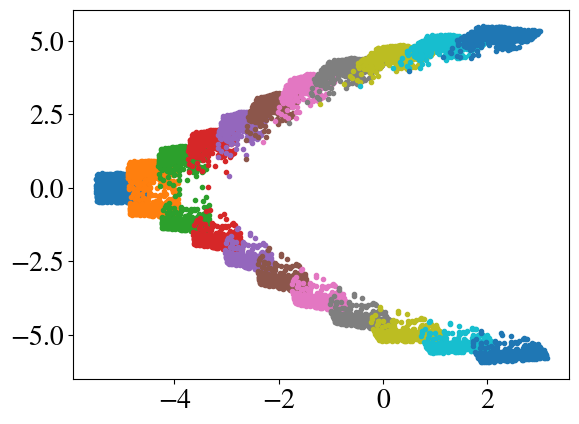

In [39]:
initial_state_range = np.array([[-5.5,-4.5],[-.5,.5]])
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=None)

Next, run your one-shot forward reachability algorithm -- just for 1 or 2 timesteps -- to see how well it bounds the "true" reachable set (as estimated by the samples):

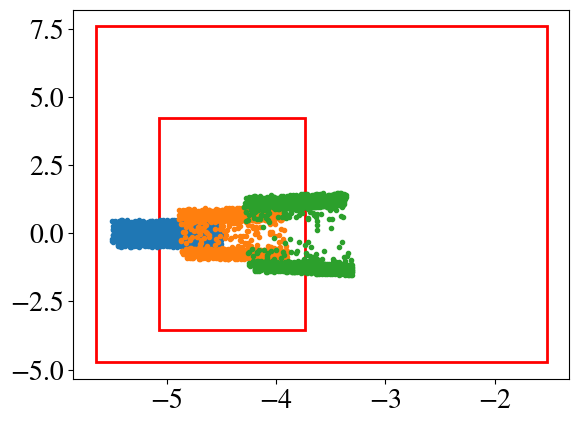

In [40]:
num_steps = 2
step_fn = functools.partial(step_T, num_steps)
output_ranges = compute_Tstep_reachable_set_one_shot(initial_state_range, step_fn, num_steps)
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=output_ranges)

The bounds will probably be quite loose. We will use backward reachability in the next problem to try to get a more useful answer.

**Yes, bounds are definitely too loose to say anything useful.**

# Problem 2: Backward Reachability Analysis

Sometimes, the forward reachable set over-approximations are way too loose to be useful, so we need a new strategy. Or other times, it may not even be important to explicitly compute the forward reachable sets. For example, if we simply want to verify that the system will not enter some part of the state space (e.g., for obstacle avoidance), we could try to directly verify that property instead.

In this problem, instead of computing forward reachable sets starting from the `initial_state_set`, we will solve the backward reachability problem. First, we will define a `target_state_set`, which describes the states we do not want our system to ever enter.

Then, we will define the `backprojection_sets` as all the states that would lead to the `target_state_set`, when following the system's dynamics and trained control policy. Since it will be intractable to compute the `backprojection_sets` exactly, we will aim to compute outer bounds on these sets.

How is this useful? Once we have these `backprojection_sets` computed, right before we let our robot start driving, we can check that it is not starting in one of the `backprojection_set` over-approximations, and if it isn't, we have a proof that the system will not enter the `target_state_set`. For an even stronger result, if you can prove that the first backprojection set is inside the target set, it follows that as long as the system starts outside of the target set, the system will never enter the target set.

## 2a) Compute "true" backprojection sets by sampling

We are trying to compute the backprojection set but it's difficult to know what this "should" look like. To get an idea (and an under-approximation), sample a bunch of points from the state space and check if the subsequent state (i.e., after running that state through the closed-loop dynamics for 1) will be inside the target set. As a hint, all of these points should be inside the target set, since this is a well-trained collision avoidance policy.

**Deliverables**:
- Implement `estimate_true_backprojection_set`
- Plot the "true" (sampling-based) backprojection set and the target set

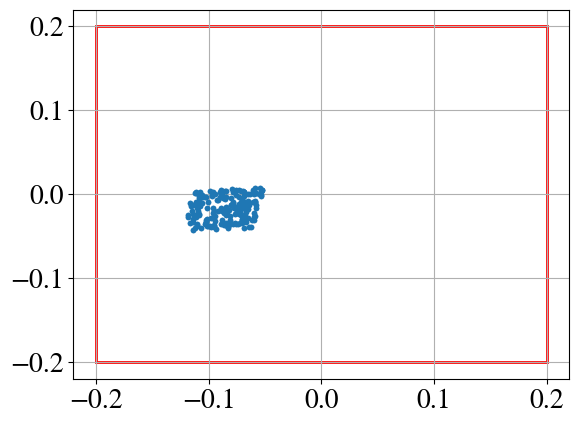

EXECUTION TIME:  1.0608031749725342  s


In [41]:
# I choose this interval because it is bigger than the target set but not too much
initial_state_range = np.array([[-1.0, 1.0], [-1.0, 1.0]])*0.6
# this is the target assigned
target_state_set = np.array([[-1.0, 1.0], [-1.0, 1.0]])*0.2

def get_true_backprojection_set(target_state_set: np.ndarray, step_fn: Callable) -> np.ndarray:

  # Return:
  # - np.array of samples within $P_1(X_t)$ (e.g., if only 13 of your 10000 samples end up in the target set, you'd return an array of size (13,2))

  n_sampling_points = int(1e5)
  xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(n_sampling_points,2))
  xt1 = step_fn(xt)
  lower_x = target_state_set[0,0]
  upper_x = target_state_set[0,1]
  lower_y = target_state_set[1,0]
  upper_y = target_state_set[1,1]

  # Use boolean indexing to extract values from the source array within the bounds
  result = xt1[ (xt1[:, 0] >= lower_x) & (xt1[:, 0] <= upper_x) &
                (xt1[:, 1] >= lower_y) & (xt1[:, 1] <= upper_y)   ]
  indexes = np.where(xt1 == result[:, np.newaxis])[1]
  #print("% of points going into the target set: ", len(indexes)/n_sampling_points*100, "%")
  true_backprojection_set = xt[indexes]
  return true_backprojection_set

start_time = time.time()
true_backprojection_set = get_true_backprojection_set(target_state_set, step_1)
end_time = time.time()

plt.plot(true_backprojection_set[:, 0], true_backprojection_set[:, 1], '.')
rect = Rectangle(
    target_state_set[[0, 1], 0],
    target_state_set[0, 1] - target_state_set[0, 0],
    target_state_set[1, 1] - target_state_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="red",
)
plt.gca().add_patch(rect)
plt.grid()
plt.show()
print("EXECUTION TIME: ", end_time-start_time, " s")

**I empirically obtain that all the points that would lead to the target state set are inside the target set (as expected). Of course, not all points in the target set lead inside the target set.**

## 2b) Compute backreachable set using LPs

Recall that for some target set, $X_t$, the backreachable set, $R_1(X_t)$, is the set of states for which *some* control within the control limits would lead the system into the target set:

$R_1(X_t) = \{ x_{t-1} | Ax_{t-1} + Bu_{t-1} \in X_t, u_{t-1} \in U \}$

Here, you'll compute rectangular outer bounds on $R_1(X_t)$ by setting up some LPs, and you'll then use these bounds in subsequent problems.

**Deliverables**:
- Implement `get_backreachable_set`
- Plot the rectangular bounds on the backreachable set, along with the target set and the "true" backprojection set from before

Backreachable set:
 [[-1.2  1.2]
 [-1.2  1.2]]


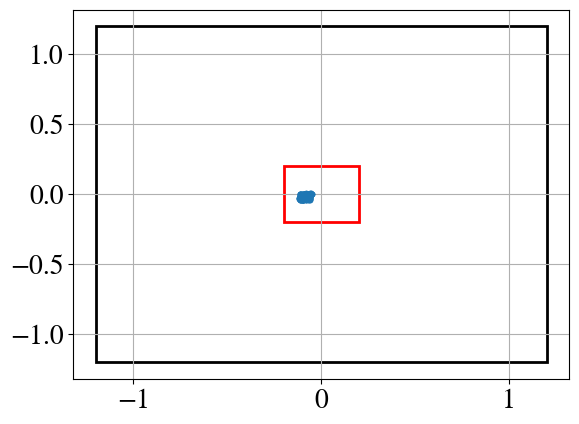

EXECUTION TIME:  0.08073663711547852  s


In [42]:
def get_backreachable_set(target_state_set: np.ndarray, dyn: dynamics.Dynamics) -> np.ndarray:

  # Hint: you may want to use dyn.At, dyn.bt, dyn.u_limits, or dyn.dynamics_step
  # Hint: you may want to use cvxpy for this

  # Defining variables and the empty list of constraints
  x_t = cp.Variable(dyn.num_states)
  u_t = cp.Variable(dyn.num_inputs)
  x_t1 = cp.Variable(dyn.num_states) # this one is not technically needed, since it does not appear in the obj function and could be calcualted on the spot. It makes the code cleaner, though.
  constraints = []

  x_t1 = dyn.dynamics_step(x_t, u_t) # as said above
  constraints += [x_t1 >= target_state_set[:,0]]
  constraints += [x_t1 <= target_state_set[:,1]]
  constraints += [u_t >= dyn.u_limits[:,0]]
  constraints += [u_t <= dyn.u_limits[:,1]]

  lower_bound = []
  upper_bound = []

  for i in range(dyn.num_states):
    objective = cp.Minimize(x_t[i])
    prob = cp.Problem(objective, constraints).solve() # quick note, solve automatically gives prob the value of the solution of the problem
    lower_bound.append(prob) # I can simply use the value of the optimization problem which is equal to the variable I was optimizing
    objective = cp.Maximize(x_t[i])
    prob = cp.Problem(objective, constraints).solve()
    upper_bound.append(prob)

  backreachable_set = np.vstack((lower_bound, upper_bound)).T # like in the previous homework

  return backreachable_set

start_time = time.time()
backreachable_set = get_backreachable_set(target_state_set, dyn)
end_time = time.time()
print("Backreachable set:\n", backreachable_set)
plt.plot(true_backprojection_set[:, 0], true_backprojection_set[:, 1], '.')
rect = Rectangle(
    target_state_set[[0, 1], 0],
    target_state_set[0, 1] - target_state_set[0, 0],
    target_state_set[1, 1] - target_state_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="red",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backreachable_set[[0, 1], 0],
    backreachable_set[0, 1] - backreachable_set[0, 0],
    backreachable_set[1, 1] - backreachable_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="black",
)
plt.gca().add_patch(rect)
plt.grid()
plt.show()
print("EXECUTION TIME: ", end_time-start_time, " s")

**Results are quite loose.**

## 2c) Compute backprojection set using LPs

In class we derived 2 ways to refine the `backreachable_set` using CROWN. You are welcome to implement either version.

- Version 1: Relax `step_1` over $\bar{R}_1(X_t)$ to get $M, n$ such that $Mx_{t-1}+n \leq Cx_t$, to get the polytope description of $\bar{P}_1(X_t)$ without solving an LP (for this HW, you probably should inflate this to a rectangle to make plotting & partitioning easier)
- Version 2: Relax `jax_controller` over $\bar{R}_1(X_t)$ to get to get $\bar{M}, \bar{n}, \bar{M}', \bar{n}'$ such that $\bar{M}'x_{t-1}+\bar{n}' \leq \pi(x_t) \leq \bar{M}x_{t-1}+\bar{n}$, then add these inequalities as additional constraints to the LP you used to get $\bar{R}_1(X_t)$.

Hint: You may want to use `backward_crown_bound_propagation_linfun`, which is a small modification to `jax_verify` to output the slope/offset of the linear bounds rather than the min/max over the domain.

**Deliverables**:
- Implement `get_backprojection_set`
- Plot the BP, BR, and "true" BP sets together

In [43]:
from nfl_veripy.utils.closed_loop_verification_jax import backward_crown_bound_propagation_linfun

# Hint: to get the linear CROWN bounds from jax_verify:
input_bounds = np_range_to_jax_interval(backreachable_set)
obj = jnp.vstack((jnp.eye(dyn.num_inputs), -jnp.eye(dyn.num_inputs)))
linfuns = backward_crown_bound_propagation_linfun(jax_controller, input_bounds, obj=obj)

# Then linfuns[0].lin_coeffs and linfuns[0].offset will contain the slope/offset from state to control
# Hint: You'll need to think about the signs of the entries in obj & linfuns to construct the inequalities properly
linfuns[0].lin_coeffs, linfuns[0].offset, linfuns[0].lin_coeffs.shape, linfuns[0].offset.shape
print("\n\nLet's see how these matrixes are made.")
print("Linear coefficients (shape):", linfuns[0].lin_coeffs.shape, "\n", linfuns[0].lin_coeffs, "\n")
print("Offset (shape):", linfuns[0].offset.shape, "\n", linfuns[0].offset, "\n")



Let's see how these matrixes are made.
Linear coefficients (shape): (4, 2) 
 [[ 2.844815   -0.8687414 ]
 [-0.19314724  3.7627962 ]
 [-2.8325763   0.8777811 ]
 [ 0.34831476 -3.2258263 ]] 

Offset (shape): (4,) 
 [-4.514737  -6.6788316 -6.527353  -7.1861987] 



Backprojection set:
 [[-1.2  1.2]
 [-1.2  1.2]]


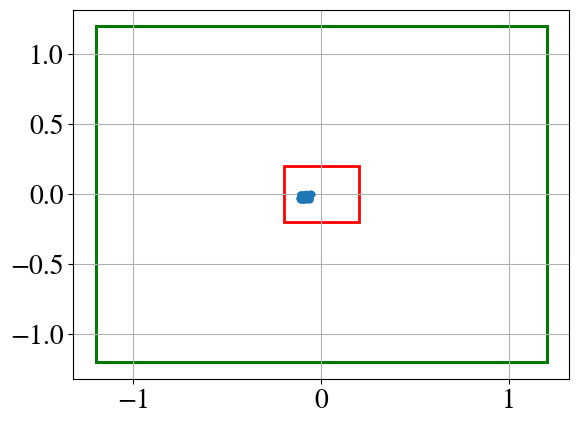

EXECUTION TIME:  0.45250725746154785  s


In [44]:
def get_backprojection_set(target_state_set: np.ndarray, dyn: dynamics.Dynamics, backreachable_set: np.ndarray, controller: Callable) -> np.ndarray:

  # Hint: you may want to use dyn.At, dyn.bt, dyn.u_limits, or dyn.dynamics_step
  # Hint: you may want to use cvxpy for this

  # The general structure of the problem is the same
  x_t = cp.Variable(dyn.num_states)
  u_t = cp.Variable(dyn.num_inputs)
  x_t1 = cp.Variable(dyn.num_states)

  constraints = []
  x_t1 = dyn.dynamics_step(x_t, u_t)
  constraints += [x_t1 >= target_state_set[:,0]]
  constraints += [x_t1 <= target_state_set[:,1]]
  constraints += [u_t >= dyn.u_limits[:,0]]
  constraints += [u_t <= dyn.u_limits[:,1]]

  # CROWN SPECIFIC CONSTRAINTS
  # I assume that linfuns is a vertical stack of coefficients for the lower and the upper bounds
  input_bounds = np_range_to_jax_interval(backreachable_set)
  obj = jnp.vstack((jnp.eye(dyn.num_inputs), -jnp.eye(dyn.num_inputs)))
  linfuns = backward_crown_bound_propagation_linfun(jax_controller, input_bounds, obj=obj)

  constraints += [u_t >= linfuns[0].lin_coeffs[0:2,:]@x_t + linfuns[0].offset[0:2]]
  constraints += [u_t <= -linfuns[0].lin_coeffs[2:4,:]@x_t - linfuns[0].offset[2:4]]

  constraints += [x_t >= backreachable_set[:,0]]
  constraints += [x_t <= backreachable_set[:,1]]
  #

  lower_bound = []
  upper_bound = []
  for i in range(dyn.num_states):
    objective = cp.Minimize(x_t[i])
    prob = cp.Problem(objective, constraints).solve()
    lower_bound.append(prob)
    objective = cp.Maximize(x_t[i])
    prob = cp.Problem(objective, constraints).solve()
    upper_bound.append(prob)

  backprojection_set = np.vstack((lower_bound, upper_bound)).T
  return backprojection_set

start_time = time.time()
backprojection_set = get_backprojection_set(target_state_set, dyn, backreachable_set, jax_controller)
end_time = time.time()
print("Backprojection set:\n", backprojection_set)
plt.plot(true_backprojection_set[:, 0], true_backprojection_set[:, 1], '.')
rect = Rectangle(
    target_state_set[[0, 1], 0],
    target_state_set[0, 1] - target_state_set[0, 0],
    target_state_set[1, 1] - target_state_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="red",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backreachable_set[[0, 1], 0],
    backreachable_set[0, 1] - backreachable_set[0, 0],
    backreachable_set[1, 1] - backreachable_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="black",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backprojection_set[[0, 1], 0],
    backprojection_set[0, 1] - backprojection_set[0, 0],
    backprojection_set[1, 1] - backprojection_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="green",
)
plt.gca().add_patch(rect)
plt.grid()
plt.show()
print("EXECUTION TIME: ", end_time-start_time, " s")

It is expected that your `backprojection_set` is the same as your `backreachable_set` at this point. This happens when the constrains induced by the CROWN relaxation are looser than the bounds induced by the control limits. You'll address this in the next part.

**Yes, the final result is the same as the LP, CROWN did not help in this case because of that.**

## 2d) Branch and Bound: Uniform Splitting

One strategy to (hopefully) get a tighter CROWN relaxation is to individually consider subsets regions of the backreachable set, then put them back together.

We provide a uniform partitioning strategy that splits the `backreachable_set` into subsets and runs your `get_backprojection_set` on each subset iteratively. The union of these BP sets should provide a much better outer bound on $P_1(X_t)$ than you had before!

Note: it's ok if some of the BP subsets are empty!

**Deliverables**:
- Run the cell below to see if you get meaningful bounds on $P_1(X_t)$
- Experiment with different numbers of partitions and show your results

In [45]:
verbose_output = False # If true, prints all the backreacable subset sets

/usr/local/lib/python3.10/dist-packages/matplotlib/patches.py:738: RuntimeWarning: invalid value encountered in double_scalars
  x1 = self.convert_xunits(self._x0 + self._width)


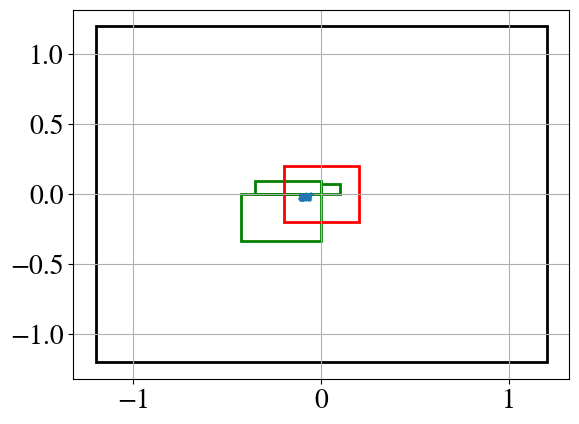

EXECUTION TIME:  4.91296124458313  s


In [46]:
start_time = time.time()

num_partitions = [4, 4]

slope = np.divide(
    (backreachable_set[:, 1] - backreachable_set[:, 0]), num_partitions
)
for element in product(
    *[range(num) for num in num_partitions]
):
    element_subset = np.array(element)
    backreachable_set_subset = np.empty_like(backreachable_set)
    backreachable_set_subset[..., 0] = backreachable_set[..., 0] + np.multiply(
        element_subset, slope
    )
    backreachable_set_subset[..., 1] = backreachable_set[..., 0] + np.multiply(
        element_subset + 1, slope
    )
    if verbose_output:
      print(backreachable_set_subset)

    backprojection_set_subset = get_backprojection_set(target_state_set, dyn, backreachable_set_subset, jax_controller)

    rect = Rectangle(
        backprojection_set_subset[[0, 1], 0],
        backprojection_set_subset[0, 1] - backprojection_set_subset[0, 0],
        backprojection_set_subset[1, 1] - backprojection_set_subset[1, 0],
        fc="None",
        linewidth=2,
        edgecolor="green",
    )
    plt.gca().add_patch(rect)

plt.plot(true_backprojection_set[:, 0], true_backprojection_set[:, 1], '.', markersize='0.5')
rect = Rectangle(
    target_state_set[[0, 1], 0],
    target_state_set[0, 1] - target_state_set[0, 0],
    target_state_set[1, 1] - target_state_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="red",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backreachable_set[[0, 1], 0],
    backreachable_set[0, 1] - backreachable_set[0, 0],
    backreachable_set[1, 1] - backreachable_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="black",
)
plt.gca().add_patch(rect)
plt.grid()
plt.show()

end_time = time.time()
print("EXECUTION TIME: ", end_time-start_time, " s")

Let's try with 16 partitions.

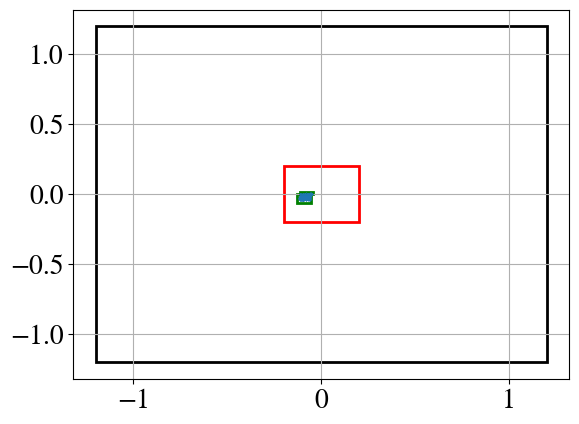

EXECUTION TIME:  97.19030404090881  s


In [47]:
start_time = time.time()
num_partitions = [16, 16]

slope = np.divide(
    (backreachable_set[:, 1] - backreachable_set[:, 0]), num_partitions
)
for element in product(
    *[range(num) for num in num_partitions]
):
    element_subset = np.array(element)
    backreachable_set_subset = np.empty_like(backreachable_set)
    backreachable_set_subset[..., 0] = backreachable_set[..., 0] + np.multiply(
        element_subset, slope
    )
    backreachable_set_subset[..., 1] = backreachable_set[..., 0] + np.multiply(
        element_subset + 1, slope
    )
    if verbose_output:
      print(backreachable_set_subset)

    backprojection_set_subset = get_backprojection_set(target_state_set, dyn, backreachable_set_subset, jax_controller)

    rect = Rectangle(
        backprojection_set_subset[[0, 1], 0],
        backprojection_set_subset[0, 1] - backprojection_set_subset[0, 0],
        backprojection_set_subset[1, 1] - backprojection_set_subset[1, 0],
        fc="None",
        linewidth=2,
        edgecolor="green",
    )
    plt.gca().add_patch(rect)

plt.plot(true_backprojection_set[:, 0], true_backprojection_set[:, 1], '.', markersize='0.5')
rect = Rectangle(
    target_state_set[[0, 1], 0],
    target_state_set[0, 1] - target_state_set[0, 0],
    target_state_set[1, 1] - target_state_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="red",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backreachable_set[[0, 1], 0],
    backreachable_set[0, 1] - backreachable_set[0, 0],
    backreachable_set[1, 1] - backreachable_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="black",
)
plt.gca().add_patch(rect)
plt.grid()
plt.show()
end_time = time.time()
print("EXECUTION TIME: ", end_time-start_time, " s")

**The green box is exactly on top of the sampling points (you need to zoom to see that)!**

# Problem 3: Extend/Improve the above algorithms in some way (Extra Credit)

There are lots of ways to potentially improve the baseline implementations  above. You can get extra credit by trying something interesting to improve the results (very open-ended). Some possible ideas:

- Implement whichever version of `get_backprojection_set` you didn't implement before to see how the results differ
- Use branch & bound to tighten the forward reachable sets on the bifurcating example (how should the branches be performed?)
- Train a new control policy that enables tighter analysis ([here](https://github.com/neu-autonomy/nfl_veripy/blob/7d2011d8800e5951d6ddc67d0674c66553523d58/src/nfl_veripy/utils/controller_generation.py#L98) is the function used to generate the controller used in this notebook)
- **If using `jax_verify`, get JIT compilation to work and see how fast the results are** ([**here**](https://github.com/google-deepmind/jax_verify/blob/fe8ea3c8da81350ca92203a5089d37c2b93f8583/jax_verify/tests/bound_propagation_test.py#L171) **is an example of how to do this)**
- Somehow apply these methods to the context of RL (e.g., define a reward function for the task and bound the set of possible accumulated rewards)
- Incorporate some noisy observation process (e.g., add uniform noise at each timestep within some known bounds) into the step function and bound calculation

I try to implement the JIT compilation. It seemed easy at the beginning, but it later turned out to be tricky.

As a quick note, JIT compilation requires to be compiled at the first run of the function. This may require a lot of time (some minutes, for example). After doing it, however, if the structure of the data remains the same, any subsequent run of the same function will be very fast.

In [26]:
from jax_verify.src import bound_propagation
import jax

num_steps = 10
step_fn = functools.partial(step_T, num_steps)

@jax.jit
def backward_crown_bound_propagation_jitted(inp_bound):
  inp_bound, = bound_propagation.unjit_inputs(inp_bound)
  bounds = (jax_verify.backward_crown_bound_propagation(step_fn, inp_bound))
  return [bounds[i].lower for i in range(len(bounds))] , [bounds[i].upper for i in range(len(bounds))]

1-step Reachable Set:
[[-4.88229   -3.8872876]
 [ 0.8987891  2.011671 ]].


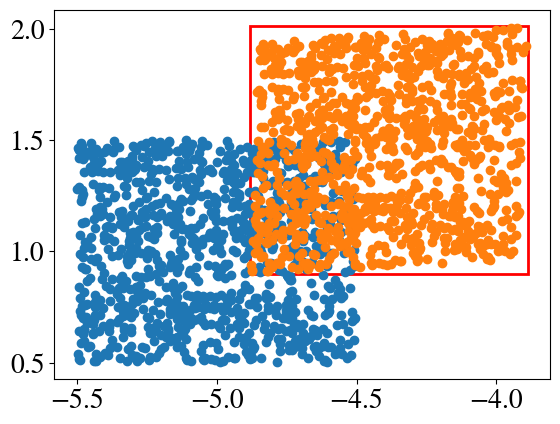

EXECUTION TIME:  168.46499752998352  s


In [27]:
# For this specific example, num_steps should be 1 and therefore the compiling would be much faster. I kept 10 for generality with the subsequent case.
initial_state_range = np.array([[-5.5,-4.5],[.5,1.5]])

def compute_1step_reachable_set(initial_state_range: np.ndarray, step_fn: Callable) -> np.ndarray:

  # - initial_state_range: np.array of size (num_states, 2) containing min/max per state
  # - step_fn: function that takes 1 argument, x_t, and outputs the subsequent state, x_{t+1}
  #
  # Returns:
  # - next_state_range: np.array of same shape as initial_state_range, but corresponding to the next timestep

  input_bounds = np_range_to_jax_interval(initial_state_range)
  input_bounds_jit = input_bounds.to_jittable()
  a,b = backward_crown_bound_propagation_jitted(input_bounds_jit)
  output_bounds_crown_jax = []
  for a1, b1 in zip(a[0:1],b[0:1]):
    output_bounds_crown_jax.append(jax_interval_to_np_range(jax_verify.IntervalBound(a1,b1)))

  next_state_range = []
  for o in output_bounds_crown_jax:
    next_state_range.append((o))

  return next_state_range[0] # needed for the structure of plot_1step_samples_and_bounds

start_time = time.time()
output_range = compute_1step_reachable_set(initial_state_range, step_1)
end_time = time.time()
print(f"1-step Reachable Set:\n{output_range}.")

# You can pass the computed output_range to the function we defined before
# and it will draw your bound as a rectangle over the sampled points:
plot_1step_samples_and_bounds(initial_state_range, step_1, bounds=output_range)
print("EXECUTION TIME: ", end_time-start_time, " s")

As noted above, this execution time includes also the compiling. The real result is shown below:

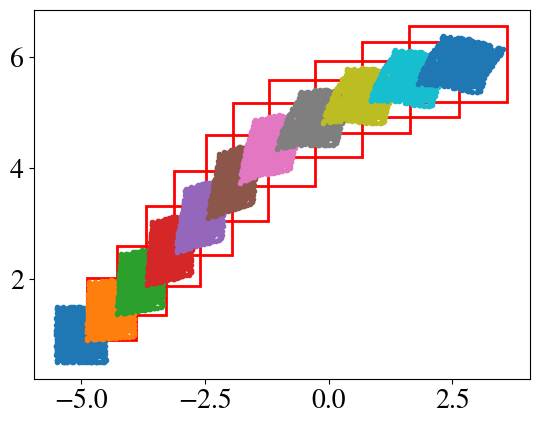

output ranges:
[[-4.88229   -3.8872876]
 [ 0.8987891  2.011671 ]]
[[-4.2751355 -3.281085 ]
 [ 1.357476   2.5879683]]
[[-3.6760807 -2.6015027]
 [ 1.878032   3.3096676]]
[[-3.111398  -1.9468963]
 [ 2.436414   3.9409275]]
[[-2.4659512 -1.2204306]
 [ 3.0502415  4.596188 ]]
[[-1.9200661 -0.2627139]
 [ 3.6702569  5.1575484]]
[[-1.211246    0.68540764]
 [ 4.184414    5.5828166 ]]
[[-0.27896404  1.6496258 ]
 [ 4.6296344   5.92227   ]]
[[0.66892576 2.6304388 ]
 [4.91829    6.2687593 ]]
[[1.6329079 3.6053257]
 [5.176407  6.542613 ]]
EXECUTION TIME:  0.010895252227783203  s


In [48]:
initial_state_range = np.array([[-5.5,-4.5],[.5,1.5]])

def compute_Tstep_reachable_set_one_shot(initial_state_range: np.ndarray, step_fn: Callable, num_steps: int) -> np.ndarray:
  #
  # initial_state_range: (num_states, 2) array containing min/max per state
  # step_fn: function that accepts array of state samples at initial timestep and returns list of state samples at times [t+1, ..., t+num_steps]
  # num_steps: non-negative integer
  #
  # Return:
  # - list of state_ranges at times [t+1, t+2, ..., t+num_steps]
  #  i.e., [(num_states, 2)_t=t+1, ..., (num_states, 2)_t=t+T]

  # TODO: implement this using
  input_bounds = np_range_to_jax_interval(initial_state_range)
  input_bounds_jit = input_bounds.to_jittable()

  a,b = backward_crown_bound_propagation_jitted(input_bounds_jit)
  output_bounds_crown_jax = []
  for a1, b1 in zip(a,b):
    output_bounds_crown_jax.append(jax_interval_to_np_range(jax_verify.IntervalBound(a1,b1)))

  output_range = []
  for o in output_bounds_crown_jax:
    output_range.append((o))

  return output_range

num_steps = 10
step_fn = functools.partial(step_T, num_steps)
start_time = time.time()
output_ranges = compute_Tstep_reachable_set_one_shot(initial_state_range, step_fn, num_steps)
end_time = time.time()
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=output_ranges)

print('output ranges:')
for output_range in output_ranges:
  print(output_range)
print("EXECUTION TIME: ", end_time-start_time, " s")


The difference is astonishing! It went from around 8 seconds to 0.01 seconds!

Now let's try with the backward analysis.

I need to run the following lines to get on the same track as the original code.

In [49]:
# I choose this interval because it is bigger than the target set but not too much
initial_state_range = np.array([[-1.0, 1.0], [-1.0, 1.0]])*0.6
# this is the target assigned
target_state_set = np.array([[-1.0, 1.0], [-1.0, 1.0]])*0.2
true_backprojection_set = get_true_backprojection_set(target_state_set, step_1)
backreachable_set = get_backreachable_set(target_state_set, dyn)

In [50]:
@jax.jit
def lin_functions_jitted(inp_bound):
  inp_bound, = bound_propagation.unjit_inputs(inp_bound)
  linfuns = (backward_crown_bound_propagation_linfun(jax_controller, inp_bound, obj=obj))
  return linfuns[0].lin_coeffs, linfuns[0].offset

Backprojection set:
 [[-1.2  1.2]
 [-1.2  1.2]]


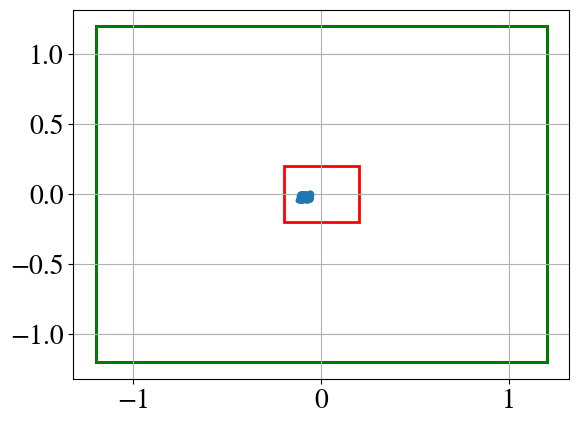

In [51]:
def get_backprojection_set(target_state_set: np.ndarray, dyn: dynamics.Dynamics, backreachable_set: np.ndarray, controller: Callable) -> np.ndarray:

  # Hint: you may want to use dyn.At, dyn.bt, dyn.u_limits, or dyn.dynamics_step
  # Hint: you may want to use cvxpy for this

  # The general structure of the problem is the same
  x_t = cp.Variable(dyn.num_states)
  u_t = cp.Variable(dyn.num_inputs)
  x_t1 = cp.Variable(dyn.num_states)

  constraints = []
  x_t1 = dyn.dynamics_step(x_t, u_t)
  constraints += [x_t1 >= target_state_set[:,0]]
  constraints += [x_t1 <= target_state_set[:,1]]
  constraints += [u_t >= dyn.u_limits[:,0]]
  constraints += [u_t <= dyn.u_limits[:,1]]

  # CROWN SPECIFIC CONSTRAINTS
  # I assume that linfuns is a vertical stack of coefficients for the lower and the upper bounds
  input_bounds = np_range_to_jax_interval(backreachable_set).to_jittable()
  obj = jnp.vstack((jnp.eye(dyn.num_inputs), -jnp.eye(dyn.num_inputs)))
  #linfuns = backward_crown_bound_propagation_linfun(jax_controller, input_bounds, obj=obj)
  lin_coeffs, offset = lin_functions_jitted(input_bounds)

  constraints += [u_t >= lin_coeffs[0:2,:]@x_t + offset[0:2]]
  constraints += [u_t <= -lin_coeffs[2:4,:]@x_t - offset[2:4]]

  constraints += [x_t >= backreachable_set[:,0]]
  constraints += [x_t <= backreachable_set[:,1]]
  #

  lower_bound = []
  upper_bound = []
  for i in range(dyn.num_states):
    objective = cp.Minimize(x_t[i])
    prob = cp.Problem(objective, constraints).solve()
    lower_bound.append(prob)
    objective = cp.Maximize(x_t[i])
    prob = cp.Problem(objective, constraints).solve()
    upper_bound.append(prob)

  backprojection_set = np.vstack((lower_bound, upper_bound)).T
  return backprojection_set

backprojection_set = get_backprojection_set(target_state_set, dyn, backreachable_set, jax_controller)
print("Backprojection set:\n", backprojection_set)
plt.plot(true_backprojection_set[:, 0], true_backprojection_set[:, 1], '.')
rect = Rectangle(
    target_state_set[[0, 1], 0],
    target_state_set[0, 1] - target_state_set[0, 0],
    target_state_set[1, 1] - target_state_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="red",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backreachable_set[[0, 1], 0],
    backreachable_set[0, 1] - backreachable_set[0, 0],
    backreachable_set[1, 1] - backreachable_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="black",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backprojection_set[[0, 1], 0],
    backprojection_set[0, 1] - backprojection_set[0, 0],
    backprojection_set[1, 1] - backprojection_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="green",
)
plt.gca().add_patch(rect)
plt.grid()
plt.show()

And let's run the most complicate scenario.

/usr/local/lib/python3.10/dist-packages/matplotlib/patches.py:738: RuntimeWarning: invalid value encountered in double_scalars
  x1 = self.convert_xunits(self._x0 + self._width)


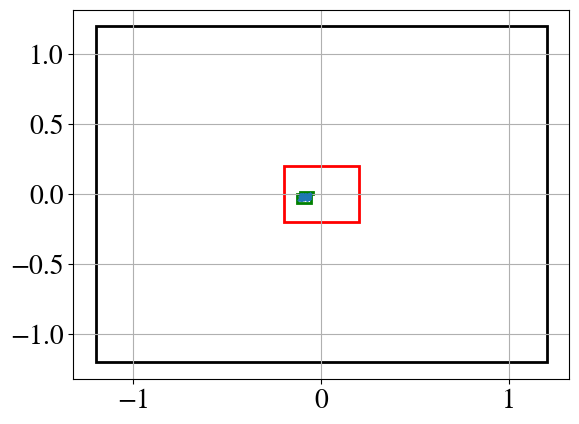

EXECUTION TIME:  23.068421125411987  s


In [52]:
start_time = time.time()
verbose_output = False
num_partitions = [16, 16]

slope = np.divide(
    (backreachable_set[:, 1] - backreachable_set[:, 0]), num_partitions
)
for element in product(
    *[range(num) for num in num_partitions]
):
    element_subset = np.array(element)
    backreachable_set_subset = np.empty_like(backreachable_set)
    backreachable_set_subset[..., 0] = backreachable_set[..., 0] + np.multiply(
        element_subset, slope
    )
    backreachable_set_subset[..., 1] = backreachable_set[..., 0] + np.multiply(
        element_subset + 1, slope
    )
    if verbose_output:
      print(backreachable_set_subset)

    backprojection_set_subset = get_backprojection_set(target_state_set, dyn, backreachable_set_subset, jax_controller)

    rect = Rectangle(
        backprojection_set_subset[[0, 1], 0],
        backprojection_set_subset[0, 1] - backprojection_set_subset[0, 0],
        backprojection_set_subset[1, 1] - backprojection_set_subset[1, 0],
        fc="None",
        linewidth=2,
        edgecolor="green",
    )
    plt.gca().add_patch(rect)

plt.plot(true_backprojection_set[:, 0], true_backprojection_set[:, 1], '.', markersize='0.5')
rect = Rectangle(
    target_state_set[[0, 1], 0],
    target_state_set[0, 1] - target_state_set[0, 0],
    target_state_set[1, 1] - target_state_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="red",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backreachable_set[[0, 1], 0],
    backreachable_set[0, 1] - backreachable_set[0, 0],
    backreachable_set[1, 1] - backreachable_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="black",
)
plt.gca().add_patch(rect)
plt.grid()
plt.show()
end_time = time.time()
print("EXECUTION TIME: ", end_time-start_time, " s")

As we can see, using JIT the time is reduced by a lot, expecially in the B&B with CROWN (from 97 s to 23 s)! Compilation time in this case was negligible.

All done!